In [1]:
import os, sys, glob, re
import datetime
from matplotlib.dates import date2num, num2date
import numpy as np
from calendar import monthrange
import h5py
from sklearn import decomposition

In [2]:
sys.path.insert(0,'/home/wu-jung/code_git/mi-instrument/')
from concat_raw import get_num_days_pings, get_data_from_h5
from echogram_decomp import find_nearest_time_idx,reshape_into_3freq,reshape_into_1freq,\
    sep_into_freq,plot_decomp_v,plot_decomp_transform

In [3]:
import matplotlib.pyplot as plt
from modest_image import imshow
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [116]:
# Set default colormap                               
plt.rcParams['image.cmap'] = 'jet'

# Get info of all files and set path                 
data_path = '/home/wu-jung/internal_2tb/ooi_sonar/figs/20170310_monthly_smpl'
save_path = '/home/wu-jung/internal_2tb/ooi_sonar/figs/20170312_sliding_win_long_del40'
fname_form = '*.h5'
fname_all = glob.glob(os.path.join(data_path,fname_form))
n_comp = 5                # number of components for NMF

In [5]:
# Constant params
fmt = '%Y%m%d'
all_hr = range(24)         # list of all hour
all_min = range(1,11)      # list of all minutes
pings_per_day = len(all_hr)*len(all_min)  # number of pings per day
max_missing_ping = 5       # maximum number of missing pings in a day

## Load data

In [7]:
f = h5py.File(os.path.join(data_path,'CE04OSPS_20150901-20150930_smpl.h5'),'r')

In [8]:
f

<HDF5 file "CE04OSPS_20150901-20150930_smpl.h5" (mode r)>

In [9]:
Sv_mtx = np.asarray(f['Sv_mtx'])
depth_tick = np.asarray(f['depth_tick'])
depth_label = np.asarray(f['depth_label'])
time_tick = np.asarray(f['time_tick'])
time_label = np.asarray(f['time_label'])
depth_bin_num = np.asarray(f['depth_bin_num'])
pings_per_day = np.asarray(f['pings_per_day'])
print 'number of days: '+str(Sv_mtx.shape[2]/pings_per_day)

number of days: 30


In [10]:
bin_size = np.int_(depth_label[-1])/depth_tick[-1]  # bin in unit [m]

In [11]:
bin_size

0.19120458891013384

In [12]:
# Take out surface reflection
num_del_idx = 40
Sv_mtx = np.delete(Sv_mtx,range(num_del_idx),axis=1)
depth_bin_num = depth_bin_num-num_del_idx
depth_max = np.int_(depth_label[-1])
depth_min = bin_size*(num_del_idx+1)

In [23]:
Sv_mtx.shape

(3, 1006, 14400)

In [20]:
%matplotlib inline

In [18]:
days_win = Sv_mtx.shape[2]/pings_per_day

In [26]:
days_win

30

## Plot echogram

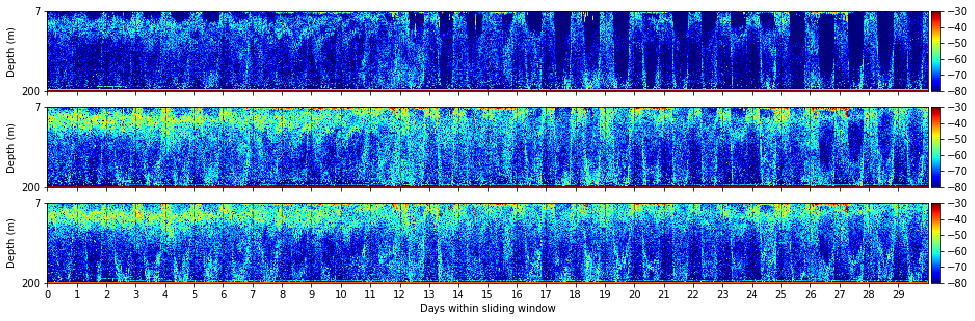

In [33]:
fig,ax = plt.subplots(3,1,sharex=True)
for ff in range(Sv_mtx.shape[0]):
    im = imshow(ax[ff],Sv_mtx[ff,:,:],aspect='auto',vmax=-30,vmin=-80)
    ax[ff].set_xticks(range(0,pings_per_day*days_win,pings_per_day))
    ax[ff].set_xticklabels([str(x) for x in range(days_win)])
    ax[ff].set_yticks((0,depth_bin_num))
    ax[ff].set_yticklabels([str(np.int_(depth_min)),str(depth_max)])
    ax[ff].set_ylabel('Depth (m)')
    if ff==2:
        ax[ff].set_xlabel('Days within sliding window')
    for dd in range(days_win):
        ax[ff].plot((dd*pings_per_day,dd*pings_per_day),(0,depth_bin_num-0.5),'k--',linewidth=0.5)
    divider = make_axes_locatable(ax[ff])
    cax = divider.append_axes("right", size="1%", pad=0.05)
    cbar = plt.colorbar(im,cax=cax)
    cbar.ax.tick_params(labelsize=10)
    fig.set_figheight(5)
    fig.set_figwidth(16)

## NMF decomposition in dB scale

In [34]:
num_comp = 5

In [40]:
vec_len_each_day = pings_per_day*depth_bin_num  # length of vector for 1 day

In [41]:
Sv_vec_tmp = reshape_into_3freq(Sv_mtx[:,:,:],vec_len_each_day)

In [42]:
Sv_vec_tmp.shape

(30, 1448640)

In [43]:
pings_per_day

array(480)

In [46]:
nmf_min = decomposition.NMF(n_components=n_comp)
W_nmf = nmf_min.fit_transform(Sv_vec_tmp-Sv_vec_tmp.min())
H_nmf = nmf_min.components_

In [52]:
H_nmf.shape

(5, 1448640)

In [69]:
# Reshape to get components in 3 frequencies
V_nmf = np.empty((num_comp,pings_per_day*3,depth_bin_num))
for c in range(num_comp):
    V_nmf[c,:,:] = H_nmf[c,:].reshape((pings_per_day*3,depth_bin_num))

In [54]:
V_nmf.shape

(5, 1440, 1006)

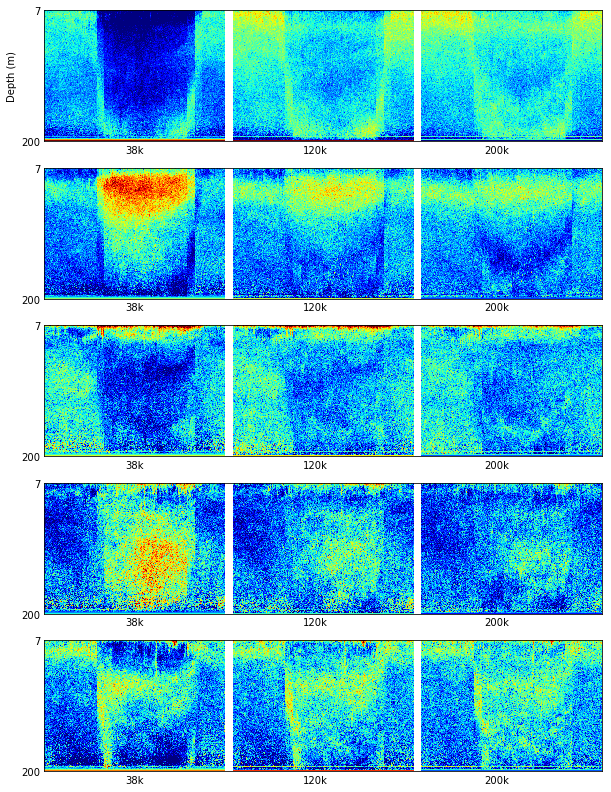

In [210]:
nan_insert = np.empty((20,depth_bin_num))
nan_insert[:] = np.nan

fig,ax=plt.subplots(5,1,sharey=True)
for c in range(num_comp):
    cmean = np.mean(V_nmf[c,:,:])
    cstd = np.std(V_nmf[c,:,:])
    cmin = max((0,cmean-2*cstd))
    cmax = min((np.max(V_nmf[c,:,:]),cmean+4*cstd))
    ax[c].imshow(np.concatenate((V_nmf[c,0:480,:],nan_insert,\
                                    V_nmf[c,480:960,:],nan_insert,\
                                    V_nmf[c,960:-1,:])).T,\
                    aspect='auto',vmax=cmax,vmin=cmin)
    ax[c].set_xticks((240,720,1200))
    ax[c].set_xticklabels(['38k','120k','200k'])
    ax[c].tick_params('both', length=0)
    ax[c].set_yticks((0,depth_bin_num))
    ax[c].set_yticklabels([str(np.int_(depth_min)),str(depth_max)])
    if c==0:
        ax[c].set_ylabel('Depth (m)')
fig.set_figwidth(10)
fig.set_figheight(14)


## NMF decomposition in linear scale

In [62]:
(Sv_vec_tmp.min(),Sv_vec_tmp.max())

(-160.96682229471506, 26.216118680392025)

In [226]:
Sv_vec_tmp_pos = Sv_vec_tmp-Sv_vec_tmp.min()

In [229]:
Sv_vec_tmp_lin = 10**(Sv_vec_tmp_pos/20)-1

In [230]:
(Sv_vec_tmp_lin.min(),Sv_vec_tmp_lin.max())

(0.0, 2286372819.4979057)

In [231]:
nmf_min_lin = decomposition.NMF(n_components=n_comp)
W_nmf_lin = nmf_min_lin.fit_transform(Sv_vec_tmp_lin)
H_nmf_lin = nmf_min_lin.components_

In [232]:
# Reshape to get components in 3 frequencies
V_nmf_lin = np.empty((num_comp,pings_per_day*3,depth_bin_num))
for c in range(num_comp):
    V_nmf_lin[c,:,:] = H_nmf_lin[c,:].reshape((pings_per_day*3,depth_bin_num))

/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


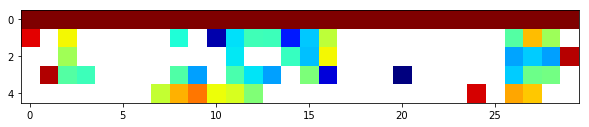

In [237]:
plt.figure(figsize=(10,5))
plt.imshow(np.log10(W_nmf_lin.T))

(array([  2.98480000e+05,   5.68242000e+05,   2.50078000e+05,
          1.09341000e+05,   6.39810000e+04,   3.65410000e+04,
          2.62750000e+04,   2.18270000e+04,   1.70960000e+04,
          1.13440000e+04,   7.18700000e+03,   4.63400000e+03,
          3.43800000e+03,   2.19000000e+03,   2.05400000e+03,
          1.56800000e+03,   1.60600000e+03,   1.00500000e+03,
          8.75000000e+02,   8.29000000e+02,   1.11600000e+03,
          6.92000000e+02,   5.59000000e+02,   6.04000000e+02,
          8.89000000e+02,   1.08400000e+03,   4.93000000e+02,
          8.48000000e+02,   4.10000000e+02,   4.11000000e+02,
          7.70000000e+02,   3.22000000e+02,   6.41000000e+02,
          3.32000000e+02,   2.32000000e+02,   1.93000000e+02,
          2.21000000e+02,   6.13000000e+02,   1.64000000e+02,
          1.49000000e+02,   1.27000000e+02,   1.48000000e+02,
          1.04000000e+02,   1.09000000e+02,   9.20000000e+01,
          8.30000000e+01,   9.20000000e+01,   9.10000000e+01,
        

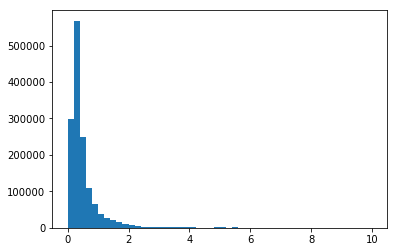

In [243]:
A = V_nmf_lin[0,:,:]
plt.hist(A[~np.isinf(A)],bins=50,range=(0,10))

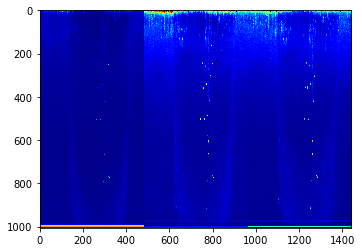

In [249]:
plt.imshow(V_nmf_lin[0,:,:].T,vmax=10,vmin=0)

In [193]:
V_nmf_lin_nozero = V_nmf_lin
V_nmf_lin_nozero[V_nmf_lin_nozero==0]=1e-30  # avoid inf issue with log

In [194]:
V_nmf_lin_log = np.log10(V_nmf_lin_nozero)

### Plot in linear domain

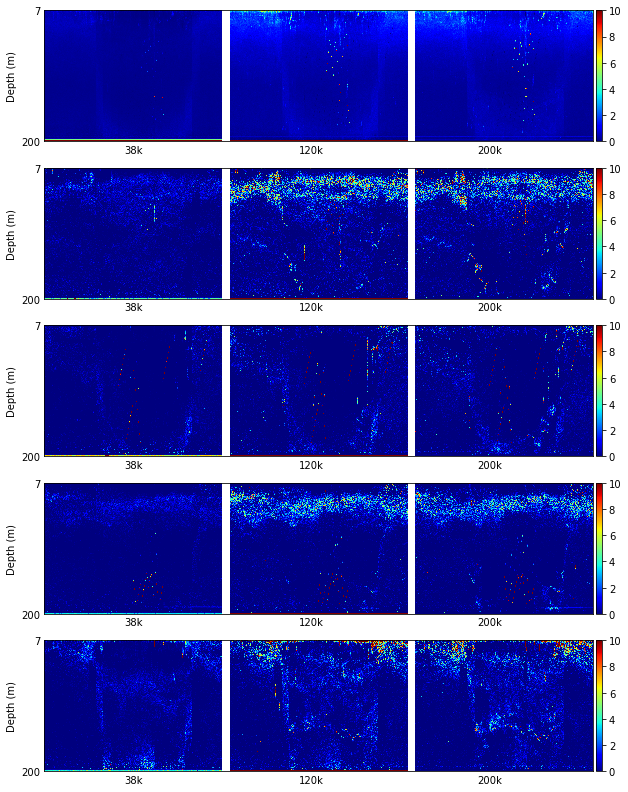

In [258]:
# Colormap
v_cmax = 10
v_cmin = 0

# Plot in log domain
nan_insert = np.empty((20,depth_bin_num))
nan_insert[:] = np.nan

fig,ax=plt.subplots(5,1,sharey=True)
for c in range(num_comp):
    cmean = np.mean(V_nmf_lin[c,:,:])
    cstd = np.std(V_nmf_lin[c,:,:])
    cmin = max((0,cmean-2*cstd))
    cmax = min((np.max(V_nmf[c,:,:]),cmean+4*cstd))
    im = ax[c].imshow(np.concatenate((V_nmf_lin[c,0:480,:],nan_insert,\
                                    V_nmf_lin[c,480:960,:],nan_insert,\
                                    V_nmf_lin[c,960:-1,:])).T,\
                    aspect='auto',vmax=v_cmax,vmin=v_cmin)
    ax[c].set_xticks((240,720,1200))
    ax[c].set_xticklabels(['38k','120k','200k'])
    ax[c].tick_params('both', length=0)
    ax[c].set_yticks((0,depth_bin_num))
    ax[c].set_yticklabels([str(np.int_(depth_min)),str(depth_max)])
    ax[c].set_ylabel('Depth (m)')
    
    divider = make_axes_locatable(ax[c])
    cax = divider.append_axes("right", size="1%", pad=0.05)
    cbar = plt.colorbar(im,cax=cax)
    cbar.ax.tick_params(labelsize=10)
fig.set_figwidth(10)
fig.set_figheight(14)

In [257]:
### Plot in log domain

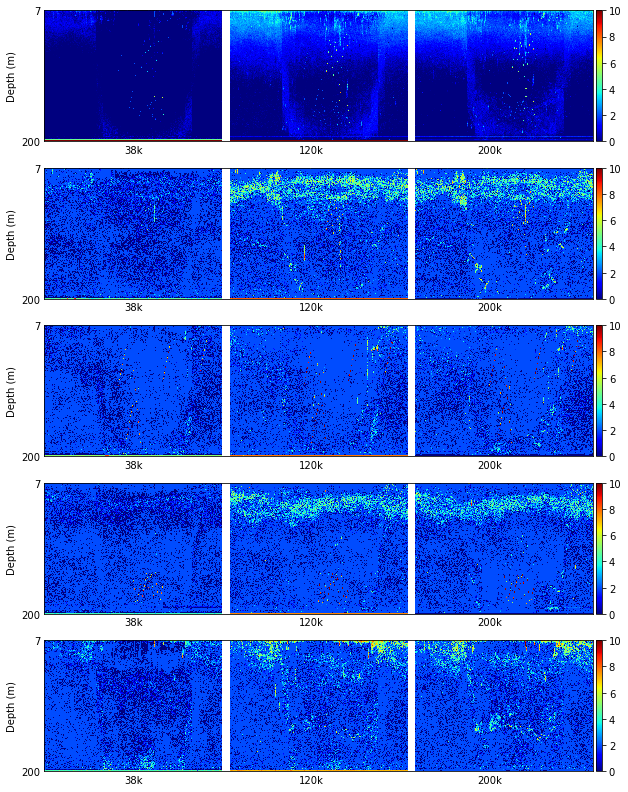

In [259]:
# Colormap
v_cmax = 2
v_cmin = -0.5

# Plot in log domain
nan_insert = np.empty((20,depth_bin_num))
nan_insert[:] = np.nan

fig,ax=plt.subplots(5,1,sharey=True)
for c in range(num_comp):
    cmean = np.mean(V_nmf_lin_log[c,:,:])
    cstd = np.std(V_nmf_lin_log[c,:,:])
    cmin = max((0,cmean-2*cstd))
    cmax = min((np.max(V_nmf[c,:,:]),cmean+4*cstd))
    ax[c].imshow(np.concatenate((V_nmf_lin_log[c,0:480,:],nan_insert,\
                                    V_nmf_lin_log[c,480:960,:],nan_insert,\
                                    V_nmf_lin_log[c,960:-1,:])).T,\
                    aspect='auto',vmax=v_cmax,vmin=v_cmin)
    ax[c].set_xticks((240,720,1200))
    ax[c].set_xticklabels(['38k','120k','200k'])
    ax[c].tick_params('both', length=0)
    ax[c].set_yticks((0,depth_bin_num))
    ax[c].set_yticklabels([str(np.int_(depth_min)),str(depth_max)])
    ax[c].set_ylabel('Depth (m)')
        
    divider = make_axes_locatable(ax[c])
    cax = divider.append_axes("right", size="1%", pad=0.05)
    cbar = plt.colorbar(im,cax=cax)
    cbar.ax.tick_params(labelsize=10)
fig.set_figwidth(10)
fig.set_figheight(14)